# Transformermodellen for prediksjon av sekvenser

In [236]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [237]:
import os
# os.environ['NUMBA_DISABLE_JIT'] = '1'
import numpy as np
import matplotlib.pyplot as plt
import importlib
import training

from training import make_model, training_sorting
from layers import CrossEntropy
from optimizer import Adam
from data_generators import get_train_test_sorting, get_train_test_addition

from training import make_model, training_addition
from testing import test_sorting
import importlib
import testing
from testing import test_addition


#### OPPGAVE 1

##### OPPGAVE 1.1

For å trene en transformermodell så trenger vi et datasett som består av flere x og y vektorer, $ D = \{ (\mathbf{x_0}, \mathbf{y_0}), (\mathbf{x_1}, \mathbf{y_1}), \ldots, (\mathbf{x_{n-1}}, \mathbf{y_{n-1}}) \} $. For å vise et eksempel på et av elementene i datasettet, $(\mathbf{x_0}, \mathbf{y_0})$, velger vi $r = 2$, $a = 43$, $b = 7$, $c = 18$ og $d = a \cdot b + c = 319$. Vektoren $\mathbf{x_0}$ er bygget opp slik at vi får de $r$ første sifferene av $a$, $b$, $c$ og $d$ og lengden til $\mathbf{x_i}$ blir dermed $4 \cdot r$. I dette tilfellet får vi da $\mathbf{x_0} = [4, 3, 0, 7, 1, 8, 3, 1]$. $\mathbf{y_0}$ består av alle sifferene til $d$ og blir her $\mathbf{y_0} = [3, 1, 9]$.  

##### OPPGAVE 1.2


Vi skal  nå anta at optimeringen er ferdig og at vi har funnet parameterene ${\theta}$ som minimerer objektfunksjonen $\mathcal{L}$, vi skal dermed bruke modellen $f_{\theta}$ til å predikere $d$ gitt $a, b$ og $c$. Modellen $f_{\theta}$ skal testes på en sekvens som bare inneholder sifferene til $a, b,$ og $c$ og vi befinner oss i testfasen. I testfasen skal $\mathbf{x}^{(0)}\in \mathbb{Z^{3r}}$, ved å kjøres gjennom modellen, få ut $f_{\theta}(x) = \mathbf{z}^{0}$ der $\mathbf{z}\in \mathbb{Z^{3r}}$, altså en sekvens av samme dimensjon.

Vi velger fortsatt $r = 2$, $a = 43$, $b = 7$ og $c = 18$ og skal predikere $d$. For å predikere $d\in \mathbb{Z^{r+1}}$ skal hver evaluering av modellen predikere neste siffer i sekvensen og legge det til bakerst i $\mathbf{x}$. Dette blir input i neste prediksjon helt til det er predikert $r+1$ nye heltall som ideelt sett skal være lik $d$. 


Vi ønsker å finne ${\theta}$ slik at $\hat{\mathbf{y}} = [\hat{z_5}, \hat{z_6}, \hat{z_7}] = [3, 1, 9]= \mathbf{y}$


Vi starter med første sekvens, $\mathbf{x}^{(0)} = [4,3,0,7,1,8]$, og setter inn i modellen $f_{\theta}([4,3,0,7,1,8]) = [\hat{z_0}^{(0)}, \hat{z_1}^{(0)},..., \hat{z_5}^{(0)}]$ 

Legger til bakerste siffer fra outputten inn i neste sekvens: $\mathbf{x}^{(1)} = [4,3,0,7,1,8, \hat{z_5}^{(0)}]$. Predikerer neste sekvens: $f_{\theta}([4,3,0,7,1,8, \hat{z_5}^{(0)}]) = [\hat{z_0}^{(1)}, \hat{z_1}^{(1)},..., \hat{z_6}^{(1)}]$ 

Gjentar prosessen: $\mathbf{x}^{(2)} = [4,3,0,7,1,8, \hat{z_5}^{(0)}, \hat{z_6}^{(1)}]$, $f_{\theta}([4,3,0,7,1,8, \hat{z_5}^{(0)}, \hat{z_6}^{(1)}] = [\hat{z_0}^{(2)}, \hat{z_1}^{(2)},..., \hat{z_7}^{(2)}]$

Etter $3$ evalueringer av modellen ender vi opp med sekvensen: $\mathbf{x}^{(3)} = [4,3,0,7,1,8, \hat{z_5}^{(0)}, \hat{z_6}^{(1)}, \hat{z_7}^{(2)}]$

Det er nå predikert $r + 1 = 3$ nye heltall, $\hat{\mathbf{y}} = [\hat{z_5}^{(0)}, \hat{z_6}^{(1)}, \hat{z_7}^{(2)}]$. Nå kan vi sammenligne den predikerte $\hat{\mathbf{y}}$ med vår $\mathbf{y} = [3, 1, 9]$. Dersom modellen har gjennomgått en god trening skal $\mathbf{z} = \hat{\mathbf{y}} = \mathbf{y} = [3,1,9]$.

##### OPPGAVE 1.3

Vi bruker cross-entropy som objektfunksjon, og setter $m = 5$ og $\mathbf{y} = [4, 3, 2, 1]$.

Dersom cross-entropy funksjonen $\mathcal{L}({\theta},D) = 0$ betyr det at modellen gir en riktig prediksjon. I et tilfelle der $\hat{Y} = F_{\theta}(x) = onehot(\mathbf{y})$ vil vi få $\mathcal{L}({\theta},D) = 0$. Dette betyr også at $\hat{\mathbf{y}} = argmax_{col}(\hat{Y})$

Matematisk sett vil vi få: 

$\hat{Y} = onehot(\mathbf{y}) = onehot([4, 3, 2, 1]) := \begin{bmatrix} 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \\\end{bmatrix}$


Fordelingen til $\hat{Y}$ tilsvarer en kollonnevis onehot fordeling, der summen av hver kolonne er $1$. For hver kolonne, $i$, vil ideksen av sifferet $1$ representere verdien til tilsvarende siffer, i  $\mathbf{y_{i}}$. Resten av matrisen $\hat{Y}$ må derfor bestå av nullere.

Slik finner vi videre $\hat{y}$ ved en kolonnevis $argmax$ operasjon:

$\hat{\mathbf{y}} = argmax_{col}(\hat{Y}) = argmax_{col}\begin{bmatrix} 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \\\end{bmatrix} = [4,3,2,1]$

Som forventet blir $\mathbf{\hat{y}}$ blir lik $\mathbf{y}$, som alltid vil stemme for denne type fordeling.

##### OPPGAVE 1.4
Gitt:
$\theta = \{ W_E, W_P, W_U, \{W_O^{(l)}, W_V^{(l)}, W_Q^{(l)}, W_K^{(l)}, W_1^{(l)}, W_2^{(l)}\} _{l=0}^{L-1}\}$

For å kunne bestemme totalt antall enkeltparamtere til transformermodellen, må vi se på dimensjonene til de forskjellige vektmatrisene.
Dimensjonen til $W_E$ og $W_U$ er $d \times m$, dimensjonen til $W_P$ er $d \times n_{max}$ , dimensjonen til ${W_O}^{(l)}, {W_V}^{(l)}, {W_Q}^{(l)}$ og ${W_K}^{(l)}$ er $k \times d$ og dimensjonen til ${W_1}^{(l)}$ og ${W_2}^{(l)}$ er $p \times d$. 

Vi får da totalt $w = 2dm + dn_{max} + (4kd + 2pd) \cdot L$ enkeltparametere som vi kan optimere.

##### OPPGAVE 1.5

Tranformermodellen er beskrevet i likning (4)-(9). Vi skal ta utgangspunkt i disse parameterene:

$n = n_{max} = 1$, $m = d = k = p = 2$, $L = 1 \rightarrow l = 0,..., L-1 = 0$ 

$W_{O} = W_{V} = W_{Q} = W_{K} = W_{1} = W_{2} = W_{u} = I_{2x2} = \begin{bmatrix} 1 & 0 \\ 0 & 1\\\end{bmatrix} $

$\sigma(x) = \text{Relu}(x) = \max(0, x)$

$ W_{E} = \begin{bmatrix} 1 & 0 \\ 0 & \alpha \end{bmatrix}$, $ W_{p} = \begin{bmatrix} 1 \\ 0\\\end{bmatrix}$

$D\in{\mathbb{R}^{n\times n}}$ er null på øvre triangulær inkludert diagonalen, slik at $n = 1$ gir $D = [0]$.

Videre vil vi vise at vi må ha $\alpha > 1$ for å få $\hat{z} = [1]$ som output når input er $x = [1]$.

Vi begynner med likning $(4)$ $X = onehot(\mathbf{x})$. Her tar vi inn en vektor $\mathbf{x}\in{\mathbb{Z}^{1}}$ og får ut en matrise $X$.

\begin{equation} 
X = \text{onehot}([1]) = \begin{bmatrix} 0 \\ 1 \end{bmatrix}, \quad X \in \mathbb{Z}^{2\times1} \tag{4}
\end{equation}


I likning $(5)$  $z_{0} = W_{E}X + [W_{p}]_{0:n}$ tar vi inn matrisen $X$ fra likning $(4)$ og får ut en matrise $z_{0}$.

\begin{equation} 
z_{0} = \begin{bmatrix} 1 & 0 \\ 0 & \alpha \\\end{bmatrix} \cdot \begin{bmatrix} 0 \\ 1\\\end{bmatrix} + \begin{bmatrix} 1 \\ 0\\\end{bmatrix} = \begin{bmatrix} 0 \\ \alpha\\\end{bmatrix} + \begin{bmatrix} 0 \\ 1\\\end{bmatrix} = \begin{bmatrix} 1 \\ \alpha\\\end{bmatrix}, \quad z_{0}\in{\mathbb{R}^{2 \times 1}} \tag{5}
\end{equation}

I likning $(6)$  $z_{\frac{1}{2}} = f_{0}^{A}(z_{0}) = z_{0} + W_{0}^{T} W_{V} z_{0} A(z_{0})$ får vi ut en matrise $z_{\frac{1}{2}}$.

For å finne denne må vi første finne $softmax_{col}$ av $z_{0}$. Det gjør vi i likning $(3)$ $A(z_{0}) = softmax_{col}(z_{0}^{T} W_{Q}^{T} W_{k} z_{0} + D)$.

\begin{equation}
A(\begin{bmatrix} 1 \\ \alpha \\\end{bmatrix}) = softmax_{col}(\begin{bmatrix} 1 & \alpha \\\end{bmatrix} \begin{bmatrix} 1 & 0 \\ 0 & 1 \\\end{bmatrix} \begin{bmatrix} 1 & 0 \\ 0 & 1 \\\end{bmatrix} \begin{bmatrix} 1 \\ \alpha\\\end{bmatrix} + [0]) = softmax_{col}(\begin{bmatrix} 1 & \alpha \\\end{bmatrix} \begin{bmatrix} 1 \\ \alpha \\\end{bmatrix} + [0]) = softmax_{col}([\alpha^{2} + 1]) = \frac{\exp^{1 + \alpha^2}}{\exp^{1 + \alpha^2}} = 1 \tag{3}
\end{equation}

Bruker så dette i likning (6):

\begin{equation}
z_{\frac{1}{2}} = f_{0}^{A}(z_{0}) = \begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix} + \begin{bmatrix} 1&0\\0&1\\\end{bmatrix} \begin{bmatrix} 1&0\\0&1\\\end{bmatrix} \begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix} A(\begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix}) = \begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix} + \begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix} = \begin{bmatrix} 2 \\ 2 \alpha \\ \end{bmatrix},\quad z_{\frac{1}{2}}\in{\mathbb{R}^{2 \times 1}} \tag{6}
\end{equation}


I likning $(7)$  $z_{1} = f_{0}^{F}(z_{\frac{1}{2}}) = z_{\frac{1}{2}} + W_{2}^{T} \sigma(W_{1}z_{\frac{1}{2}})$ skal vi få ut en matrise $z_{1}$.

\begin{equation}
z_{1} = f_{0}^{F}(z_{\frac{1}{2}}) = \begin{bmatrix} 2 \\ 2 \alpha \\\end{bmatrix} + \begin{bmatrix} 1&0\\0&1\\\end{bmatrix} \sigma (\begin{bmatrix}2\\2\alpha\\\end{bmatrix}) = \begin{bmatrix}2\\2\alpha\\\end{bmatrix} + max(0,\begin{bmatrix}2\\2\alpha\\\end{bmatrix}), \quad z_{1}\in{\mathbb{R}^{2\times1}} \tag{7}
\end{equation}

Her får vi to utfall:

\begin{equation}
For\, \alpha > 0:\, \begin{bmatrix}2\\2\alpha\\\end{bmatrix} + max(0,\begin{bmatrix}2\\2\alpha\\\end{bmatrix}) = \begin{bmatrix}2\\2\alpha\\\end{bmatrix} + \begin{bmatrix}2\\2\alpha\\\end{bmatrix} = \begin{bmatrix}4\\4\alpha\\\end{bmatrix},\quad z_{1}\in{\mathbb{R}^{2\times1}} \tag{7.1}
\end{equation}

\begin{equation}
For\, \alpha < 0:\,\begin{bmatrix}2\\2\alpha\\\end{bmatrix} + max(0,\begin{bmatrix}2\\2\alpha\\\end{bmatrix}) = \begin{bmatrix}2\\2\alpha\\\end{bmatrix} + \begin{bmatrix}2\\0\\\end{bmatrix} = \begin{bmatrix}4\\2\alpha\\\end{bmatrix},\quad z_{1}\in{\mathbb{R}^{2\times1}} \tag{7.2}
\end{equation}


I likning $(8)$  $Z = softmax_{col}(W_{U}^{T}z_{L})$ får vi ut en matrise.

\begin{equation}
For \, \alpha > 0: softmax_{col}(\begin{bmatrix}4\\4\alpha\\\end{bmatrix}) = \begin{bmatrix}  \frac{e^{4}}{e^{4} + e^{4\alpha}} \\  \frac{e^{4\alpha}}{e^{4} + e^{4\alpha}} \\\end{bmatrix}, \quad Z\in{\mathbb{R}^{2\times1}} \tag{8.1}
\end{equation}

\begin{equation}
For \, \alpha < 0: softmax_{col}(\begin{bmatrix}4\\2\alpha\\\end{bmatrix}) = \begin{bmatrix} \frac{e^{4}}{e^{4} + e^{2\alpha}} \\ \frac{e^{2\alpha}}{e^{4} + e^{2\alpha}} \\\end{bmatrix}, \quad Z\in{\mathbb{R}^{2\times1}} \tag{8.2}
\end{equation}


I likning $(9)$ $\hat{z} = argmax_{col}(Z)$ får vi ut et matrise.

\begin{equation}
For \, \alpha > 0: argmax_{col}(\begin{bmatrix}  \frac{e^{4}}{e^{4} + e^{4\alpha}} \\  \frac{e^{4\alpha}}{e^{4} + e^{4\alpha}} \\\end{bmatrix}), \quad \hat{z}\in\mathbb{Z}^{1} \tag{9.1}
\end{equation}

\begin{equation}
For \, \alpha < 0: argmax_{col}(\begin{bmatrix}  \frac{e^{4}}{e^{4} + e^{2\alpha}} \\  \frac{e^{2\alpha}}{e^{4} + e^{2\alpha}} \\\end{bmatrix}), \quad \hat{z}\in\mathbb{Z}^{1} \tag{9.2}
\end{equation}

For at $\hat{z} = 1$ må vi ha at det nederste elementet i vektoren være størst, altså:

I likning $(8.1)$ får vi dermed $\frac{e^{4\alpha}}{e^{4} + e^{4\alpha}} > \frac{e^{4}}{e^{4} + e^{4\alpha}}$ $\rightarrow$ $\alpha > 1$

Tilsvarende for likning $(8.2):$ $\frac{e^{2\alpha}}{e^{4} + e^{2\alpha}} > \frac{e^{4}}{e^{4} + e^{2\alpha}}$ $\rightarrow$ $\alpha > 2$

I likning $(8.2)$ får vi både $\alpha < 0$, $\alpha > 2$, og dette gir $L = \emptyset$.
Vi har dermed eneste gyldige løsning $\alpha > 1$ for at $\hat{z} = 1. \quad \blacksquare$

#### OPPGAVE 2

##### Oppgave 2.1
Transformermodellen vår består av et nevralt nettverk, som vi har implementert i neural_network.py. Vi har brukt objektorientert programmering til å lage alle lagene, som er  i nettverket. Baseklassen Layer inneholder forward(), backward() og step_gd() som er funksjonene til lagene. Neural_network klassen bruker flere lag og kjører forward pass, backward pass og gradient descent på alle lagene. 

Grunnen til at vi bruker objektorientert programmering er at lagene skal kunne arve fra hverandre. I tillegg vil dette gi en ryddig og strukturert kode. Klassen Layer er baseklassen, med flere underklasser. Alle underklassene arver funksjonene fra Layer, underklassene overskriver forward() og backward() funksjonene fra Layer slik at de er tilpasset det spesifikke laget. step_gd() er en optimeringsalgoritme og denne vil arves av resten av lagene. (Det er kun de lagene med parametere), altså lag som ikke inneholder underlag, som beholder step_gd() som definert i Layer. Resten av lagene inneholder underlag og vi har derfor overskrevet funksjonen slik at den kan bruke step_gd() når den går gjennom hvert av underlagene. 

Vårt nevrale nettverk er bygget opp av lagene EmbedPosition, TransformerBlock, LinearLayer og Softmax, som igjen er bygget opp av flere underliggende lag. NeuralNetwork bruker arv når den utfører gradient descent på lagene ved at de enten arver fra et av de overliggende lagene, eller overskriver step_gd() slik at den selv kan utføre gradient descent.

##### Oppgave 2.2

I vår implementering av transformermodellen har vi valgt en annen struktur enn utdelt kode, der vi har implementert flere lag. Vi skal nå forklare hvordan disse er satt sammen.

Vi har delt Attention opp i flere lag, der SelfAttantion er øverst. Hovedoppgaven til SelfAttention er at den skal gjøre det mulig for det nevrale nettverket å fokusere på spesifikke deler av den innhentede dataen. Dette gjør det enklere å håndtere lange sekven ser av data og (fokusere på relevante deler av dataen) identifisere viktige mønstre. 
SelfAttention:
Her brukes attention som er basert på "queries", "keys", og "values" jobber sammen for å bestemme hvor mye vekt eller 'attention' som skal tilegnes forskjellige deler av inputen.


I forward passet til Attention tar vi inn ‘queries, ‘keys’ og ‘values’, disse tre jobber sammen for å bestemme hvor mye vekt eller attention som skal tilegnes forskjellige deler av inputen. Den returnerer vektmatrisen ganget med attention,
I backward kalkulerer vi loss gradienten med hensyn på en rekke variabler.

Inni Attention blir det benyttet et annet underlag, Softmax. Dette laget utfører kollonevis softmax operasjon, som tar inn en tre dimensjonal matrise $x$ skalerer verdiene i matrisen til en kolonnevis sannsynlighetsfordeling. Backward vil returnere gradienten til lossen med hensyn på $z_l$ som er hentet fra forward passet. 

Både Attention og Softmax benyttes inni SelfAttention. Vi overskriver derfor step_gd() fra baseklassen Layers fordi vi ønsker å utføre en iterasjon av gradient descent på alle vektmatrisene.


CrossEntropy, eller Loss funksjonen, evaluerer feilen mellom modellens prediksjoner og de faktiske resultatene. I forward tar vi inn de predikerte y-veridene av dimensjon (batch, n, m) og de sanne y-verdiene med dimensjon (batch, n) og beregner loss per sekvens. I backward beregnes gradienten. 
 
Unembedding er et lineært lag med dimensjon (d,m).

I TransformerBlock laget settes SelfAttantion og FeedForward lagene sammen, 


Relu er aktiveringsfunksjonen vi tar i bruk. Denne er viktig fordi den introduserer ikke-linearitet i det ellers lineære systemet vårt. Uten denne ville vi ikke kunne fått fram komplekse relasjoner i dataene, ettersom at en serie med lineære operasjoner kan bli redusert til èn enkelt lineær operasjon. Forward i Relu tar simpelt inn en matrise og returnerer samme dimensjon bare at alle element som var negative før er nå null. Backward tar inn gradienten og returnerer den multiplisert med den deriverte av Relu.  
 


LinearLayer: Representerer et lag i et nevralt nettverk med flereinnebygde lineærtransformasjoner. Den lagrer tilfeldige weights i en nøstet dictionary.
Forward passet tar inn et 3 dimensjonalt x-array og ved hjelp av lineære transformasjon (matrise multiplikasjon) sender den ut ett 3-dimensjonalt y-array.
Backward passet finner gradienten av loss funskjonen med hensyn til

batched_mm: Utfører matrise multiplikasjon for to arrays som enten har dimensjon 2 eller 3.  Vi lagde denne her for å ha en systematsik måte å multiplisere matriser av varierende dimensjoner.
 
Matmul: Forward passet tar inn to matriser og returnerer en multiplisert matrise ved hjelp av batched_mm(). Backwardpasset tar inn en matrise som er produktet av to matriser og returnere de to produkt matrisene. Reversert matrise multiplikasjon.
 
D-matirsen: En nedre trianguler matrise der alle elemente under diagonalen er -inf og over er 0.

EmbedPosition: Forward passet tar inn et tre dimensjonalt one_hot encoded array og returnerer et 3 dimensjonalt array: z_0 = W_E*X + W_P[:,:n].
Det utføres en matrise multiplikasjon og en posisjonering.
Backward gjør vi et linear layer backwardpass og returnerer ingenting fordi dette vil alltid være det siste laget i en backward passende
Overskriver sted_gd() fra base klassen Layers for å kunne kjøre den på hvert lag.

 
FeedForward:

##### Oppgave 2.3
Adam er en optimeringsalgoritme som er raskere enn gradient descent. Vi har implementert Adam ved å lage en ny foreldreklasse Optimizer og en barneklasse Adam. Dette gjør koden vår mer generell som gjør det mulig å lage flere optimaliseringsalgoritmer som kan brukes i nettverket. I Adam er det definert to nye variabler M, momentum, og V som gir informasjon om tidligere deriverte, dette skal forbedre algoritmen. Vi har derfor endret step_gd() til å ta inn Optimizer som en parameter. Parameterne blir lagt til i den nøstede dictionaryen hver gang dataen går gjennom et underlag ved step_gd(). 


Numba
I prosjektoppgaven vår har flere større beregninger og jo større nettverket er jo langer kjøretid får vi. For å minimere kjøretiden har vi kun brukt numpy, og har derav endret en del i koden som var laget fra før. Dette er gjort slik at vi koden skal kunne kompilleres ved hjelp av jit og njit (‘A ~5 minute guide to Numba’). I objektorientert programmering ved numba må vi på forhånd si hvilke variabler som skal bli definert inni klassen, så før hver klasse har vi laget en @jitclass med nye variabler og deres type.  


##### Oppgave 3.1

#### Oppgave 3.2
Printer gjennomsnittet av objektfunskjonen(losset) over batchene :
$\mathscr{L}^{j} = \frac{1}{B}  \sum_{k=0}^{B-1}\mathcal{L}^{j}_{k}$

Losset skal bli mindre for hver iterasjon

Training model: 100%|██████████| 100/100 [00:29<00:00,  3.40it/s, loss=0.826, accuracy=0.615]


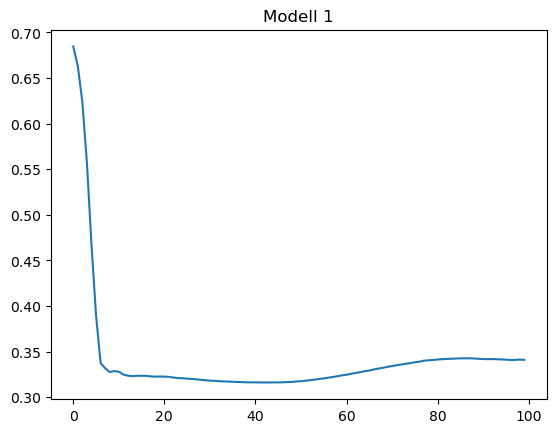

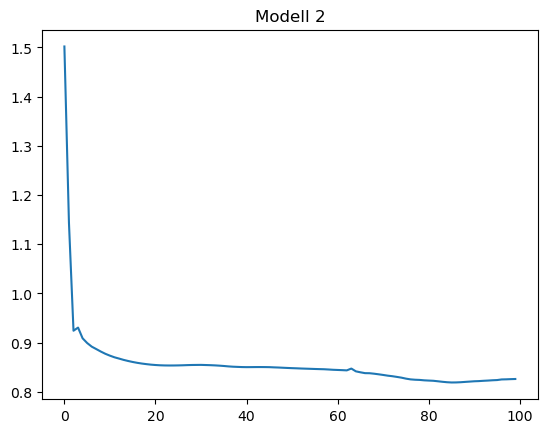

In [239]:
n = 100

test_model_1 = make_model(r=5, d=10, m=2, L=2, p=15, k=5)
test_model_2 = make_model(r=7, d=20, m=5, L=2, p=25, k=10)

sorting_data1 = get_train_test_sorting(5, 2, 250, 10, 10)
trained_model1, mean_loss_arr1 = training_sorting(test_model_1, CrossEntropy(), Adam(), sorting_data1, 2, n_epochs=n, r=5)

sorting_data2 = get_train_test_sorting(7, 5, 250, 20, 20)
trained_model2, mean_loss_arr2 = training_sorting(test_model_2, CrossEntropy(), Adam(), sorting_data2, 5, n_epochs=n, r=7)

iter = np.arange(n)

plt.title("Modell 1")
plt.plot(iter, mean_loss_arr1)
plt.show()
plt.title("Modell 2")
plt.plot(iter, mean_loss_arr2)
plt.show()

In [240]:
accuracy1 = test_sorting(trained_model1, sorting_data1, m=2)
print(f'Accuracy for model 1: {np.round(accuracy1, 1)}%')

accuracy2 = test_sorting(trained_model2, sorting_data2, m=5)
print(f'Accuracy for model 2: {np.round(accuracy2, 1)}%')

Accuracy for model 1: 81.2%
Accuracy for model 2: 46.3%


Training model: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s, loss=1.73, accuracy=0.294]


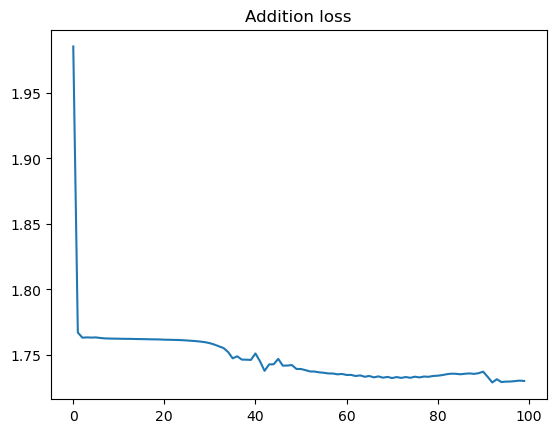

In [241]:
n = 100

test_model_add = make_model(r=6, d=30, m=10, L=3, p=40, k=20)
addition_data = get_train_test_addition(n_digit=2, samples_per_batch=250, n_batches_train=20, n_batches_test=20)

trained_model_add, mean_loss_arr_add = training_addition(test_model_add, CrossEntropy(), Adam(), addition_data, 10, n_epochs=n, r=2)

iter = np.arange(n)

plt.title("Addition loss")
plt.plot(iter, mean_loss_arr_add)
plt.show()

In [242]:
accuracy_addition = test_addition(trained_model_add, addition_data, m=10)
print(f'Accuracy for model: {np.round(accuracy_addition, 1)}%')

Accuracy for model: 13.0%
